import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import glob
import torch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

from theoretical_analysis import plot_step_function, beta_to_sigma
import theoretical_analysis.planted_submatrix_analysis as submatrix
import theoretical_analysis.sparse_nnpca_analysis as gaussiannnpca

plot_dir = "plots/"
Path(plot_dir).mkdir(parents=True, exist_ok=True)
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = ["Computer Modern Roman"]
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{amssymb} \usepackage{mathptmx}"
)
figsize = (4, 3)
axes_rect = [0.12, 0.1, 0.85, 0.85]

fixed_y_range = False
fontsize = 18
offset = 0.05

/cis/home/yma93/miniconda3/envs/nonlinear_laplacian/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Planted Submatrix
## Z-shaped piecewise linear function
Consider $\sigma(x) = \begin{cases} 0 & x< c\\ b\frac{x-c}{a}& c<x<a+c \\ b & x>a+c\end{cases}$

0.7650237606415122 [ 7.41704791  4.40851134 -5.20518863]


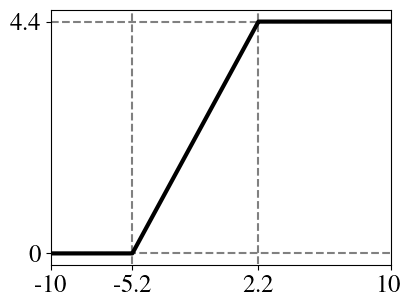

In [2]:
with open("logs/planted_submatrix/optimization_zshape.pkl", "rb") as f:
    res = pickle.load(f)
print(res.fun, res.x)
gamma = res.x
x = np.arange(-10, 10, 0.01)
y = [min(gamma[1], max(0, gamma[1] / gamma[0] * (x_i - gamma[2]))) for x_i in x]
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x, y, color="black", linewidth=3)
ax.set_xticks([-10, res.x[2], res.x[0] + res.x[2], 10])
ax.set_yticks([0, res.x[1]])
ax.set_xticklabels([-10, f"{res.x[2]:.1f}", f"{res.x[0] + res.x[2]:.1f}", 10], fontsize=fontsize)
ax.set_yticklabels([0, f"{res.x[1]:.1f}"], fontsize=fontsize)

ax.vlines(res.x[2], -0.2, 10, linestyle="--", color="grey", zorder=1)
ax.vlines(res.x[0] + res.x[2], -0.2, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[1], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(0, -10, 10, linestyle="--", color="gray", zorder=1)
if fixed_y_range:
    ax.set_ylim(-offset * 5.3, 5.3 + offset * 5.3)
    fname = "planted_submatrix_zshape_fixed_y.pdf"
else:
    y_range = res.x[1]
    ax.set_ylim(-offset * y_range, res.x[1] + offset * y_range)
    fname = "planted_submatrix_zshape.pdf"
ax.set_xlim(-10, 10)
fig.savefig(Path(plot_dir) / fname)
plt.show()
plt.close(fig)

### Heatmaps

In [3]:
def plot_heatmap(data, extent, xlabel, ylabel, title, filename, cmap, norm):
    plt.figure(figsize=(5, 4))
    plt.imshow(
        data,
        extent=extent,
        origin="lower",
        aspect="auto",
        cmap=cmap,
        norm=norm,
    )
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Add colorbar with custom ticks
    cbar = plt.colorbar(label=r"$\beta_*$")
    cbar.ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: rf"$\geq 1$" if x == 1 else f"{x:.2f}")
    )
    cbar.set_label(r"$\beta_*$", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.title(title, fontsize=24)
    plt.tight_layout()
    plt.savefig(Path(plot_dir) / filename)
    plt.show()

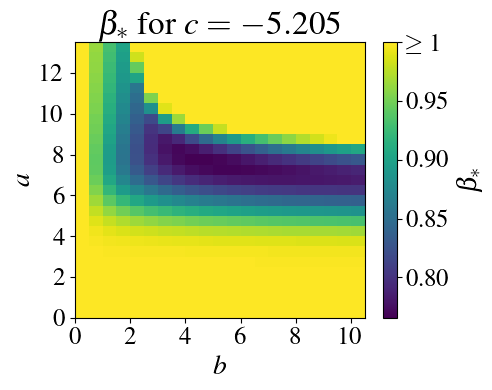

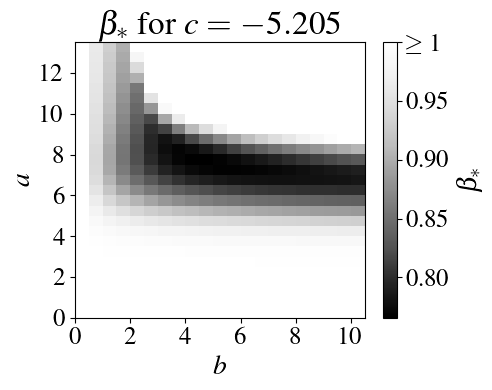

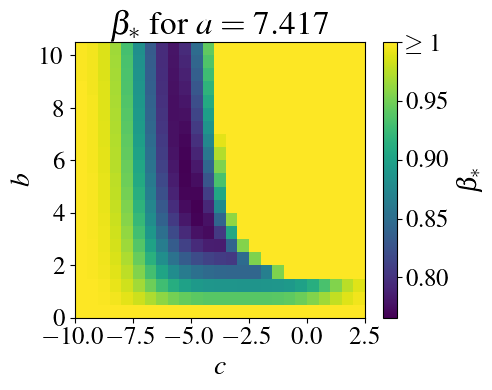

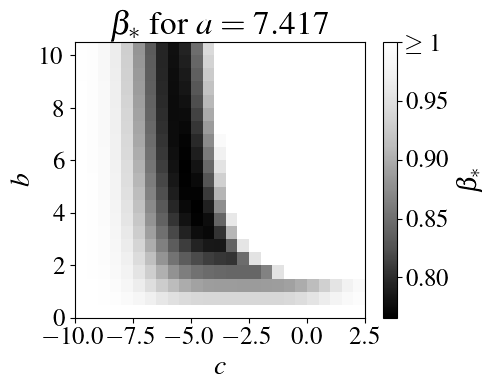

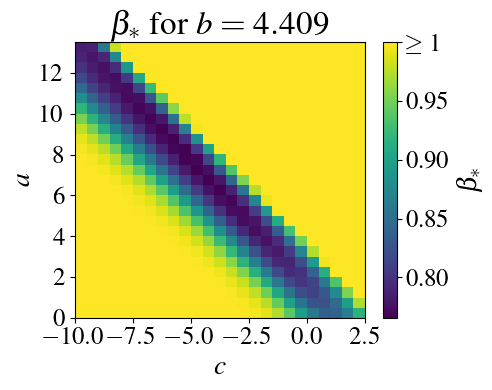

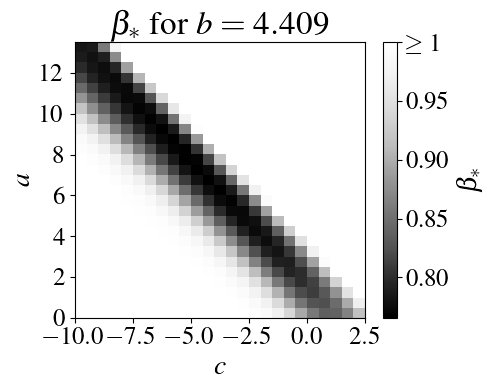

In [4]:
# Load optimization results
with open("logs/planted_submatrix/optimization_zshape.pkl", "rb") as f:
    res = pickle.load(f)

# First heatmap
a_range, b_range, fix_c = pickle.load(
    open(f"logs/planted_submatrix/c_criticals_c={res.x[-1]}.pkl", "rb")
)
norm = mcolors.Normalize(vmin=fix_c.min(), vmax=1)  # Normalize with max capped at 1

# Color version
plot_heatmap(
    fix_c,
    extent=[b_range[0], b_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$b$",
    ylabel=r"$a$",
    title=rf"$\beta_*$ for $c={res.x[-1]:.3f}$",
    filename="planted_submatrix_zshape_fix_c_color.pdf",
    cmap="viridis",
    norm=norm,
)

# Black and white version
plot_heatmap(
    fix_c,
    extent=[b_range[0], b_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$b$",
    ylabel=r"$a$",
    title=rf"$\beta_*$ for $c={res.x[-1]:.3f}$",
    filename="planted_submatrix_zshape_fix_c_bw.pdf",
    cmap="Greys_r",
    norm=norm,
)

# Second heatmap
b_range, c_range, fix_a = pickle.load(
    open(f"logs/planted_submatrix/c_criticals_a={res.x[0]}.pkl", "rb")
)
norm = mcolors.Normalize(vmin=fix_a.min(), vmax=1)  # Normalize with max capped at 1

# Color version
plot_heatmap(
    fix_a,
    extent=[c_range[0], c_range[-1], b_range[0], b_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$b$",
    title=rf"$\beta_*$ for $a={res.x[0]:.3f}$",
    filename="planted_submatrix_zshape_fix_a_color.pdf",
    cmap="viridis",
    norm=norm,
)

# Black and white version
plot_heatmap(
    fix_a,
    extent=[c_range[0], c_range[-1], b_range[0], b_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$b$",
    title=rf"$\beta_*$ for $a={res.x[0]:.3f}$",
    filename="planted_submatrix_zshape_fix_a_bw.pdf",
    cmap="Greys_r",
    norm=norm,
)

# Third heatmap
a_range, c_range, fix_b = pickle.load(
    open(f"logs/planted_submatrix/c_criticals_b={res.x[1]}.pkl", "rb")
)
norm = mcolors.Normalize(vmin=fix_b.min(), vmax=1)  # Normalize with max capped at 1

# Color version
plot_heatmap(
    fix_b,
    extent=[c_range[0], c_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$a$",
    title=rf"$\beta_*$ for $b={res.x[1]:.3f}$",
    filename="planted_submatrix_zshape_fix_b_color.pdf",
    cmap="viridis",
    norm=norm,
)

# Black and white version
plot_heatmap(
    fix_b,
    extent=[c_range[0], c_range[-1], a_range[0], a_range[-1]],
    xlabel=r"$c$",
    ylabel=r"$a$",
    title=rf"$\beta_*$ for $b={res.x[1]:.3f}$",
    filename="planted_submatrix_zshape_fix_b_bw.pdf",
    cmap="Greys_r",
    norm=norm,
)

## $a\tanh(bx)$

In [5]:
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
print(res.fun, res.x)

0.7550073892984475 [1.70974534 0.58384117]


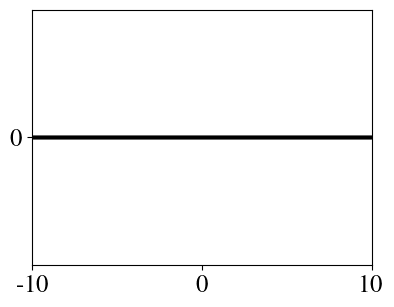

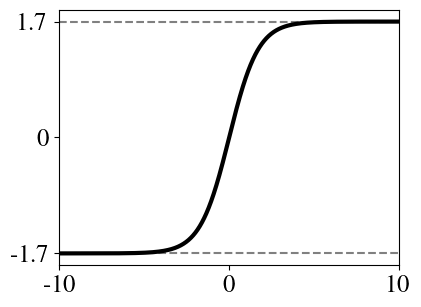

In [6]:
# plot zero sigma and learned sigma
x = np.arange(-10, 10, 0.01)

# Plot zero sigma
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x, np.zeros_like(x), color="black", linewidth=3)
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=18)
ax.set_yticks([0])
ax.set_yticklabels([0], fontsize=18)
ax.set_xlim(-10, 10)
fig.savefig(Path(plot_dir) / "zero_sigma.pdf")
plt.show()
plt.close(fig)

# Plot learned sigma
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x, res.x[0] * np.tanh(res.x[1] * x), color="black", linewidth=3)
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=fontsize)
ax.set_yticks([-res.x[0], 0, res.x[0]])
ax.set_yticklabels([f"{-res.x[0]:.1f}", "0", f"{res.x[0]:.1f}"], fontsize=fontsize)
ax.hlines(-res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
if fixed_y_range:
    ax.set_ylim(-res.x[0] - offset * 5.3, -res.x[0] + 5.3 + offset * 5.3)
    fname = "planted_submatrix_tanh_fixed_y.pdf"
else:
    y_range = res.x[0] * 2
    ax.set_ylim(-res.x[0] - offset * y_range, res.x[0] + offset * y_range)
    fname = "planted_submatrix_tanh.pdf"
fig.savefig(Path(plot_dir) / fname)
plt.show()
plt.close(fig)

### Histogram of eigenvalues

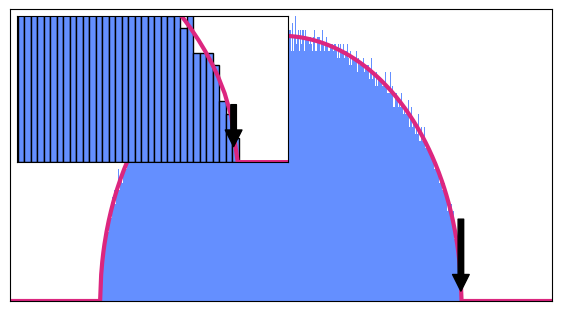

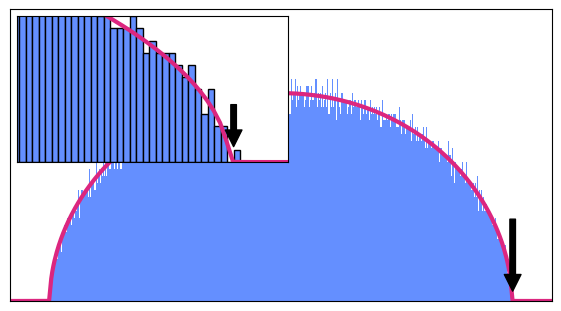

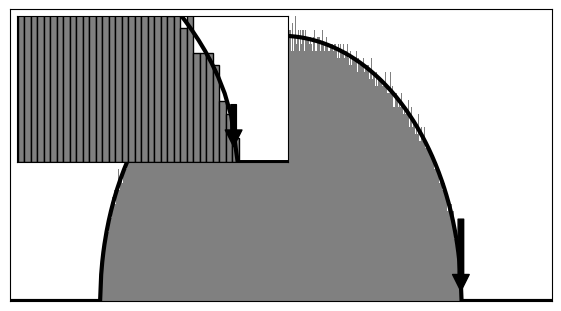

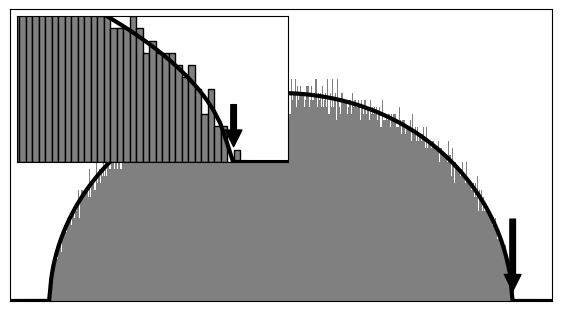

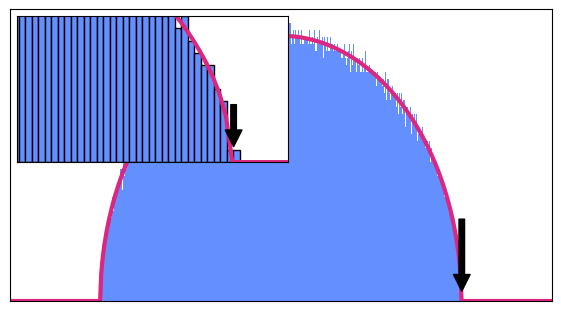

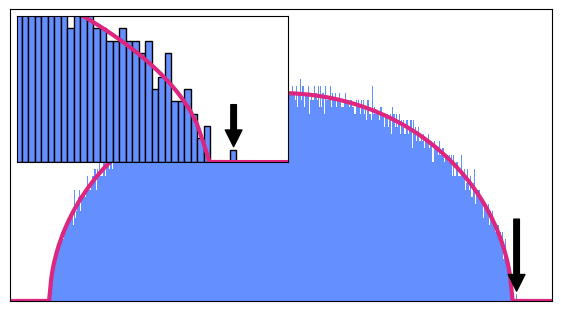

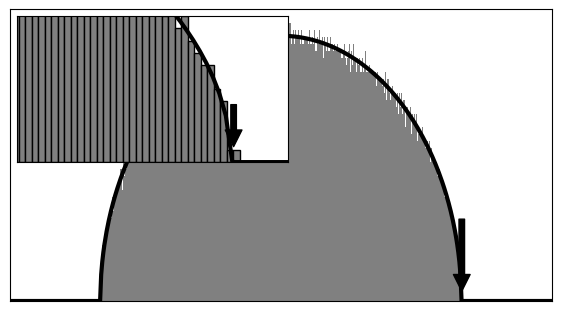

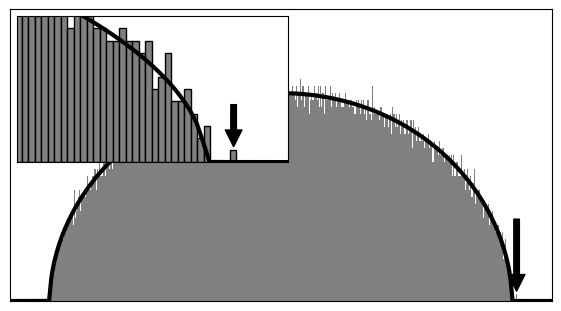

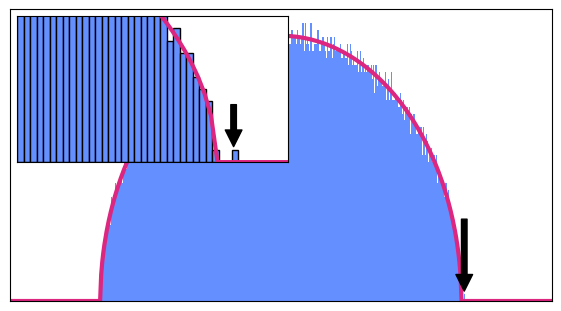

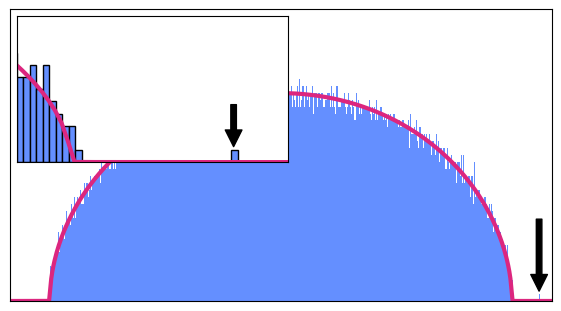

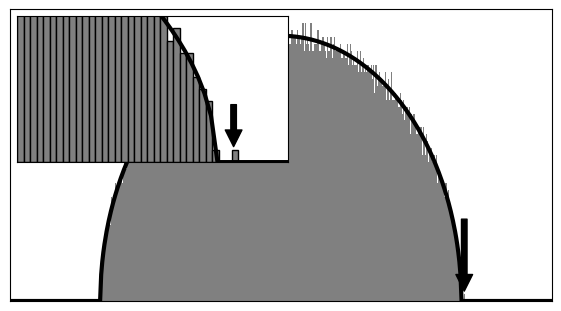

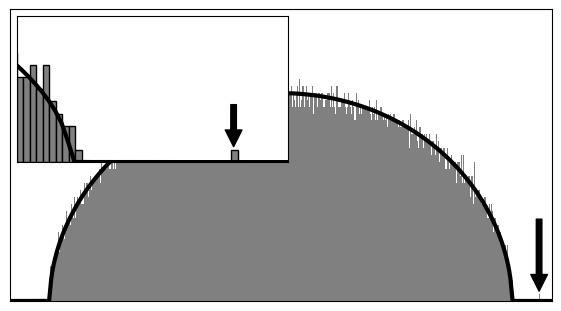

In [7]:
def plot_histograms(results, beta, fname, use_bw=False):
    # Define colors and styles based on the mode
    hist_color = "#648FFF" if not use_bw else "grey"
    line_color = "#dc267f" if not use_bw else "black"
    arrow_color = "black"
    edge_color = "black"  # Outline color for the bins

    # Plot for A_p_evals
    A_p_evals, L_p_evals, x, sc, free_conv = results[beta]
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        A_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.1),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax.plot(x, sc, label="Analytic prediction", color=line_color, linewidth=3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])

    # Inset for zoomed-in A_p_evals
    ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper left")
    ax_inset.hist(
        A_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        edgecolor=edge_color,  # Add outline to bins
        range=(-3, 3),
    )
    ax_inset.annotate(
        "",
        xy=(A_p_evals[-1], 0.01),
        xytext=(A_p_evals[-1], 0.04),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax_inset.plot(x, sc, color=line_color, linewidth=3)
    ax_inset.set_xlim(A_p_evals[-1] - 0.4, A_p_evals[-1] + 0.1)
    ax_inset.set_ylim(0, 0.1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    suffix = "_bw" if use_bw else "_color"
    fig.savefig(Path(plot_dir) / f"direct_beta={beta}_combined{suffix}.pdf")
    plt.show()
    plt.close(fig)

    # Plot for L_p_evals
    fig, ax = plt.subplots(figsize=(5.5, 3), constrained_layout=True)
    ax.hist(
        L_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        label="Histogram of eigenvalues",
        range=(-3, 3),
    )
    ax.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.1),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax.plot(x, free_conv, label="Analytic prediction", color=line_color, linewidth=3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 0.35)
    ax.set_xticks([])
    ax.set_yticks([])

    # Inset for zoomed-in L_p_evals
    ax_inset = inset_axes(ax, width="50%", height="50%", loc="upper left")
    ax_inset.hist(
        L_p_evals,
        bins=500,
        density=True,
        color=hist_color,
        edgecolor=edge_color,  # Add outline to bins
        range=(-3, 3),
    )
    ax_inset.annotate(
        "",
        xy=(L_p_evals[-1], 0.01),
        xytext=(L_p_evals[-1], 0.04),
        arrowprops=dict(facecolor=arrow_color, shrink=0.02),
    )
    ax_inset.plot(x, free_conv, color=line_color, linewidth=3)
    ax_inset.set_xlim(L_p_evals[-1] - 0.4, L_p_evals[-1] + 0.1)
    ax_inset.set_ylim(0, 0.1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    fig.savefig(fname)
    plt.show()
    plt.close(fig)


# Load data
with open(f"logs/planted_submatrix/tanh_eigenvalues_n=10000.pkl", "rb") as f:
    results = pickle.load(f)

# Generate plots for each beta
for beta in results.keys():
    # Color version
    plot_histograms(
        results,
        beta,
        Path(plot_dir) / f"planted_submatrix_tanh_histogram_beta={beta}_color.pdf",
        use_bw=False,
    )

    # Black-and-white version
    plot_histograms(
        results,
        beta,
        Path(plot_dir) / f"planted_submatrix_tanh_histogram_beta={beta}_bw.pdf",
        use_bw=True,
    )

### Phase transition for eigenvalue and eigenvector

In [8]:
def plot_eigenvalues_and_vectors(results, betas, res, filename, use_bw=False):
    fig, ax = plt.subplots(2, 1, figsize=(6, 4))

    # Define colors or grayscale styles
    color_sigma_0 = "#648fff" if not use_bw else "black"
    color_sigma_tanh = "#fe6100" if not use_bw else "gray"
    prediction_color = "#dc267f" if not use_bw else "black"
    linestyle_sigma_0 = "-" if not use_bw else "--"
    linestyle_sigma_tanh = "-" if not use_bw else "-."
    prediction_marker = "^"

    # First plot
    ax[0].plot(
        betas,
        [results[beta][0].mean() for beta in betas],
        label=r"$\sigma(x)=0$",
        color=color_sigma_0,
        linestyle=linestyle_sigma_0,
    )
    ax[0].fill_between(
        betas,
        [results[beta][0].mean() - results[beta][0].std() for beta in betas],
        [results[beta][0].mean() + results[beta][0].std() for beta in betas],
        alpha=0.5 if not use_bw else 0.5,
        color=color_sigma_0,
    )
    ax[0].plot(
        betas,
        [results[beta][2].mean() for beta in betas],
        label=r"$\sigma(x)=a\tanh(bx)$",
        color=color_sigma_tanh,
        linestyle=linestyle_sigma_tanh,
    )
    ax[0].fill_between(
        betas,
        [results[beta][2].mean() - results[beta][2].std() for beta in betas],
        [results[beta][2].mean() + results[beta][2].std() for beta in betas],
        alpha=0.5 if not use_bw else 0.5,
        color=color_sigma_tanh,
    )
    ax[0].plot(
        betas[::5],
        [results[beta][4] for beta in betas][::5],
        label="Theoretical predictions",
        color=prediction_color,
        marker=prediction_marker,
        markersize=5,
        linestyle="None",
    )

    # Second plot
    ax[1].plot(
        betas,
        [results[beta][1].mean() for beta in betas],
        label=r"$\sigma(x)=0$",
        color=color_sigma_0,
        linestyle=linestyle_sigma_0,
    )
    ax[1].fill_between(
        betas,
        [results[beta][1].mean() - results[beta][1].std() for beta in betas],
        [results[beta][1].mean() + results[beta][1].std() for beta in betas],
        alpha=0.5 if not use_bw else 0.5,
        color=color_sigma_0,
    )
    ax[1].plot(
        betas,
        [results[beta][3].mean() for beta in betas],
        label=r"$\sigma(x)=a\tanh(bx)$",
        color=color_sigma_tanh,
        linestyle=linestyle_sigma_tanh,
    )
    ax[1].fill_between(
        betas,
        [results[beta][3].mean() - results[beta][3].std() for beta in betas],
        [results[beta][3].mean() + results[beta][3].std() for beta in betas],
        alpha=0.5 if not use_bw else 0.5,
        color=color_sigma_tanh,
    )
    # ax[1].plot(
    #     betas,
    #     [results[beta][5] for beta in betas],
    #     label="Theoretical predictions",
    #     color=prediction_color,
    # )
    # ax[1].plot(
    #     betas,
    #     [results[beta][6] for beta in betas],
    #     label="Theoretical predictions",
    #     color=prediction_color,
    # )
    ax[1].plot(
        [-1],
        [-1],
        label="Theoretical predictions",
        color=prediction_color,
        marker=prediction_marker,
        markersize=5,
        linestyle="None",
    )
    ylim = math.ceil(results[betas[-1]][2].mean())
    # Vertical lines
    ax[0].vlines(1, 0, ylim, linestyle="--", color=color_sigma_0)
    ax[0].vlines(res.fun, 0, ylim, linestyle="--", color=color_sigma_tanh)
    ax[1].vlines(1, 0, 1, linestyle="--", color=color_sigma_0)
    ax[1].vlines(res.fun, 0, 1, linestyle="--", color=color_sigma_tanh)

    # Text annotations
    ax[0].text(1, ylim + 0.1, r"$\beta_*=1$", color="black", ha="center", fontsize=12)
    ax[0].text(
        res.fun,
        ylim + 0.1,
        rf"$\beta_*={res.fun:.2f}$",
        color="black",
        ha="right",
        fontsize=12,
    )

    # Axis limits and labels
    ax[0].set_ylim(1, ylim)
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(betas[0], betas[-1])
    ax[1].set_xlim(betas[0], betas[-1])
    ax[0].set_ylabel(r"$\lambda_1(L)$", fontsize=14)
    ax[1].set_ylabel(r"$\langle {v}_1(L), {x} \rangle^2$", fontsize=14)
    ax[1].set_xlabel(r"$\beta$", fontsize=14)
    ax[0].set_xticklabels([])
    ax[1].tick_params(axis="x", labelsize=12)
    ax[0].tick_params(axis="y", labelsize=12)
    ax[1].tick_params(axis="y", labelsize=12)

    # Legend
    ax[1].legend(loc="lower right", fontsize=10)

    # Save and show
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [9]:
# Load data
n = 2000
N = 500
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
with open(f"logs/planted_submatrix/tanh_top_eigen_n={n}_N={N}.pkl", "rb") as f:
    results = pickle.load(f)

# sigma = lambda x: res.x[0] * np.tanh(res.x[1] * x)
# for beta in betas:
#     if beta < res.fun:
#         lower_bound = 0
#         upper_bound = 0
#     else:
#         theta = submatrix.theta(c=beta, sigma=sigma, sigma_image=[-res.x[0], res.x[0]], tol=2e-12)
#         x_vx = submatrix.X_eigenvector(c=beta, theta=theta, sigma=sigma)
#         vx_vl = submatrix.H_prime(
#             z=theta,
#             sigma=sigma,
#             sigma_image=[-res.x[0], res.x[0]],
#         )
#         lower_bound = max(0, (np.sqrt(x_vx * vx_vl) - np.sqrt((1 - x_vx) * (1 - vx_vl)))) ** 2
#         upper_bound = (np.sqrt(x_vx * vx_vl) + np.sqrt((1 - x_vx) * (1 - vx_vl))) ** 2

#     results[beta].extend([lower_bound, upper_bound])

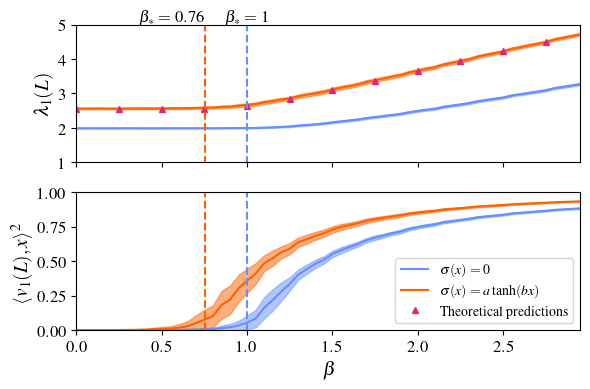

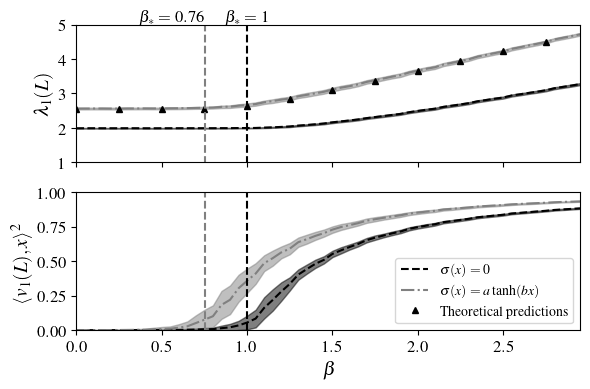

In [10]:
# Generate color version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=Path(plot_dir) / "planted_submatrix_tanh_eigenvectors_color.pdf",
    use_bw=False,
)

# Generate black-and-white version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=Path(plot_dir) / "planted_submatrix_tanh_eigenvectors_bw.pdf",
    use_bw=True,
)

## Planted clique phase transition

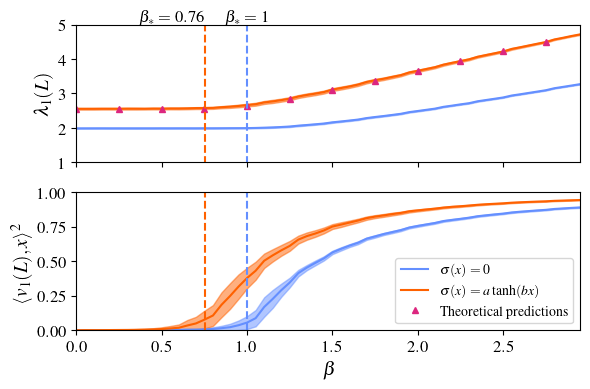

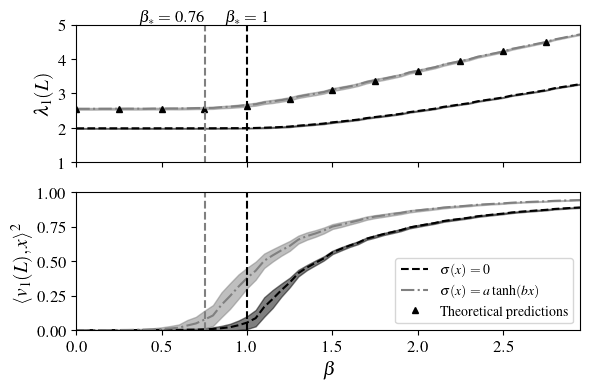

In [11]:
# Load data
n = 2000
N = 500
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
with open(f"logs/planted_clique/tanh_top_eigen_n={n}_N={N}.pkl", "rb") as f:
    results = pickle.load(f)

# Generate color version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=Path(plot_dir) / "planted_clique_tanh_eigenvectors_color.pdf",
    use_bw=False,
)

# Generate black-and-white version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=Path(plot_dir) / "planted_clique_tanh_eigenvectors_bw.pdf",
    use_bw=True,
)

## Step functions

In [12]:
with open("logs/planted_submatrix/optimization_step.pkl", "rb") as f:
    results = pickle.load(f)

0.7548625372061667


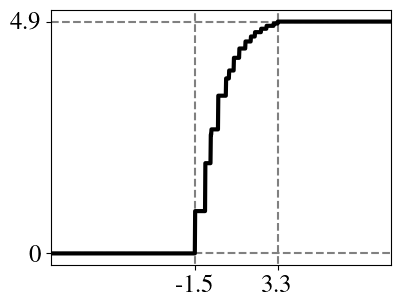

In [13]:
results_list = [results[str(seed)][2].fun for seed in range(10)]
argmin_seed = np.argmin(results_list)
print(results_list[argmin_seed])
plot_step_function(
    np.array(results[str(argmin_seed)][2].x),
    f"{plot_dir}planted_submatrix_step_function_NM_n=15.pdf",
    figsize=figsize,
    axes_rect=axes_rect,
    fixed_y_range=fixed_y_range,
    fontsize=fontsize,
    offset=offset,
)

## Learned from data

In [14]:
from learning_from_data.train import NNTrainingModule

with open("logs/planted_submatrix/NN_planted_submatrix_tanh.pkl", "rb") as f:
    results = pickle.load(f)
run_id_with_best_beta = min(results.keys(), key=lambda run_id: results[run_id][1])
beta = results[run_id_with_best_beta][1]
print(beta)
fname = glob.glob(
    os.path.join(
        f"learning_from_data/nonlinear_laplacian/{run_id_with_best_beta}/checkpoints/epoch*"
    )
)[0]
best_model = NNTrainingModule.load_from_checkpoint(fname, map_location=None)
best_model.eval()


x_s = torch.linspace(-10, 10, 1000)
x_tensor = x_s.reshape(-1, 1).float().to(best_model.device)
output = best_model.model.mlp(x_tensor).detach().squeeze().cpu().numpy()
y_s = np.maximum.accumulate(output)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes(axes_rect)
ax.plot(x_s, y_s, color="black", linewidth=3)
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=fontsize)
ax.set_yticks([y_s[0], y_s[-1]])
ax.set_yticklabels([f"{y_s[0]:.1f}", f"{y_s[-1]:.1f}"], fontsize=fontsize)
ax.hlines(y_s[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(y_s[-1], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
if fixed_y_range:
    ax.set_ylim(y_s[0] - offset * 5.3, y_s[0] + 5.3 + offset * 5.3)
    fname = "planted_submatrix_mlp_learned_sigma_fixed_y.pdf"
else:
    y_range = y_s[-1] - y_s[0]
    ax.set_ylim(y_s[0] - offset * y_range, y_s[-1] + offset * y_range)
    fname = "planted_submatrix_mlp_learned_sigma.pdf"
fig.tight_layout()
fig.savefig(Path(plot_dir) / fname)
plt.show()

0.7592213526704277


NameError: name 'os' is not defined

# Gaussian Sparse NNPCA
Sparse NNPCA with $\eta = \mathrm{Law}(|g|), g\sim N(0,1), p=\beta/\sqrt{n}$

## $a\tanh(bx)$

In [ ]:
with open("logs/gaussian_sparse_nnpca/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
print(res.fun, res.x)

0.661658086101911 [2.17506053 0.57475203]


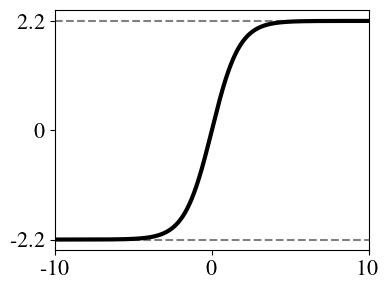

In [ ]:
x = np.arange(-10, 10, 0.01)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, res.x[0] * np.tanh(res.x[1] * x), color="black", linewidth=3)
# ax.set_xlabel(r"$x$")
# ax.set_ylabel(r"$\sigma(x)$")
ax.set_xticks([-10, 0, 10])
ax.set_xticklabels([-10, 0, 10], fontsize=16)
ax.set_yticks([-res.x[0], 0, res.x[0]])
ax.set_yticklabels([f"{-res.x[0]:.1f}", "0", f"{res.x[0]:.1f}"], fontsize=16)
ax.hlines(-res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.hlines(res.x[0], -10, 10, linestyle="--", color="gray", zorder=1)
ax.set_xlim(-10, 10)
if fixed_y_range:
    ax.set_ylim(-res.x[0] - offset * 5.3, -res.x[0] + 5.3 + offset * 5.3)
    fname = "gaussian_sparse_nnpca_tanh_fixed_y.pdf"
else:
    y_range = res.x[0] * 2
    ax.set_ylim(-res.x[0] - offset * y_range, res.x[0] + offset * y_range)
    fname = "gaussian_sparse_nnpca_tanh.pdf"
fig.tight_layout()
fig.savefig(Path(plot_dir) / fname)
plt.show()
plt.close(fig)

### Transferability analysis

In [ ]:
# Use sigma learned from gaussian sparse NNPCA on planted submatrix
with open("logs/gaussian_sparse_nnpca/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
    print(f"beta^* for gaussian sparse NNPCA:{res.fun}")
    beta_star = submatrix.c_critical(
        c_range=[0.5, 1],
        sigma=lambda x: res.x[0] * np.tanh(res.x[1] * x),
        sigma_image=[-res.x[0], res.x[0]],
        plot=False,
    )
print(f"beta^* for planted submatrix: {beta_star}")

beta^* for gaussian sparse NNPCA:0.661658086101911
beta^* for planted submatrix: 0.766690339565534


In [ ]:
# Use sigma learned from planted submatrix on gaussian sparse NNPCA
with open("logs/planted_submatrix/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
    print(f"beta^* for planted submatrix:{res.fun}")
    beta_star = gaussiannnpca.c_critical(
        c_range=[0.5, 1],
        sigma=lambda x: res.x[0] * np.tanh(res.x[1] * x),
        sigma_image=[-res.x[0], res.x[0]],
        plot=False,
    )
print(f"beta^* for gaussian sparse NNPCA: {beta_star}")

beta^* for planted submatrix:0.7550073892984475
beta^* for gaussian sparse NNPCA: 0.6732137034008591


### Phase transition for eigenvalue and eigenvectors

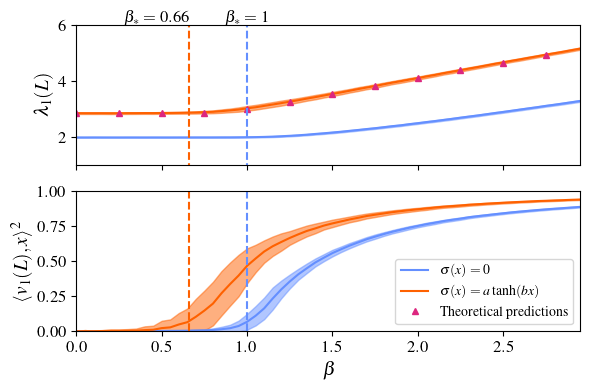

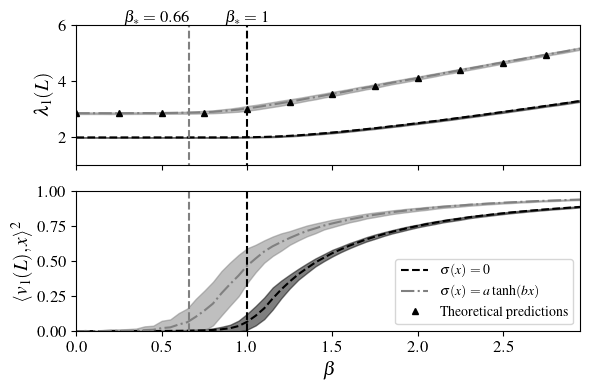

In [ ]:
n = 2000
N = 500
np.random.seed(0)
betas = np.arange(0, 3, 0.05)
with open("logs/gaussian_sparse_nnpca/optimization_tanh.pkl", "rb") as f:
    res = pickle.load(f)
with open(f"logs/gaussian_sparse_nnpca/tanh_top_eigen_n={n}_N={N}.pkl", "rb") as f:
    results = pickle.load(f)

# Generate color version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=Path(plot_dir) / "gaussian_sparse_nnpca_tanh_eigenvectors_color.pdf",
    use_bw=False,
)

# Generate black-and-white version
plot_eigenvalues_and_vectors(
    results,
    betas,
    res,
    filename=Path(plot_dir) / "gaussian_sparse_nnpca_tanh_eigenvectors_bw.pdf",
    use_bw=True,
)

## Step functions

[0.6653413481249374, 0.6651901629454996, 0.6650899802628537, 0.6655966164925887, 0.6652096353143142, 0.6656171664988285, 0.6658827566872411, 0.6643409465804812, 0.6654399671563908, 0.6664160350200127]
0.6643409465804812


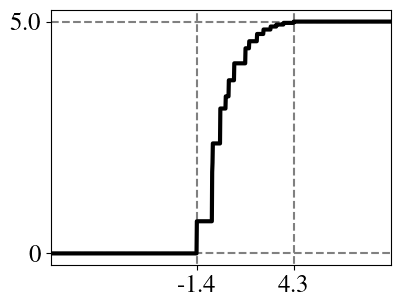

In [ ]:
with open("logs/gaussian_sparse_nnpca/optimization_step.pkl", "rb") as f:
    results = pickle.load(f)
results_list = [results[str(seed)][2].fun for seed in range(len(results))]
print(results_list)
argmin_seed = np.argmin(results_list)
print(results_list[argmin_seed])
plot_step_function(
    np.array(results[str(argmin_seed)][2].x),
    f"{plot_dir}step_function_NM_n=15.pdf",
    figsize=figsize,
    axes_rect=axes_rect,
    fixed_y_range=fixed_y_range,
    fontsize=fontsize,
    offset=offset,
)

### Transferability analysis

In [ ]:
# Use sigma learned from gaussian sparse NNPCA on planted submatrix
with open("logs/gaussian_sparse_nnpca/optimization_step.pkl", "rb") as f:
    results = pickle.load(f)
    results_list = [results[str(seed)][2].fun for seed in range(len(results))]
    argmin_seed = np.argmin(results_list)
    res = results[str(argmin_seed)][2]
print(f"beta^* for gaussian sparse NNPCA:{res.fun}")
beta_star = submatrix.c_critical_discrete(
    c_range=[0.5, 1],
    sigma=beta_to_sigma(res.x),
    plot=False,
)
print(f"beta^* for planted submatrix: {beta_star}")

beta^* for gaussian sparse NNPCA:0.6643409465804812
beta^* for planted submatrix: 0.7672976726494543


In [ ]:
# Use sigma learned from planted submatrix on gaussian sparse NNPCA
with open("logs/planted_submatrix/optimization_step.pkl", "rb") as f:
    results = pickle.load(f)
    results_list = [results[str(seed)][2].fun for seed in range(len(results))]
    argmin_seed = np.argmin(results_list)
    res = results[str(argmin_seed)][2]
print(f"beta^* for planted submatrix:{res.fun}")
beta_star = gaussiannnpca.c_critical_discrete(
    c_range=[0.5, 1],
    sigma=beta_to_sigma(res.x),
    plot=False,
)
print(f"beta^* for gaussian sparse NNPCA: {beta_star}")

beta^* for planted submatrix:0.7548625372061667
beta^* for gaussian sparse NNPCA: 0.6746633495434047
